In [ ]:
# hide
# all_tutorial
! [ -e /content ] && pip install -Uqq mrl-pypi  # upgrade mrl on colab

# Example Workflows - Latent Optimization

>Basic latent optimization workflow

## Latent Optimization Workflows

This notebook shows a basic workflow for optimizing a latent vector relative to a generative model. The focus here is on showing how to set up the code, rather than maximizing performance. For this reason, we will use a simple template and a simple reward function.

During latent optimization, we will create several latent vectors. Upon initialisation, these latent vectors will map to compounds with some score. We will then use gradient descent to optimize these vectors to produce high scoring compounds while keeping the generative model constant

In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates.all import *

from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.vocab import *
from mrl.policy_gradient import *
from mrl.train.all import *
from mrl.model_zoo import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Agent

Here we create the model we want to optimize. We will use the `FP_Cond_LSTM_LM_Small_ZINC` - a LSTM-based conditionl language model pretrained on part of the ZINC database.

Note that for latent optimization we specifically need a conditional generative model

In [ ]:
agent = FP_Cond_LSTM_LM_Small_ZINC(drop_scale=0.5,opt_kwargs={'lr':5e-5}, base_model=None)

Here we freeze the weights of the model so that the model won't be updated during training

In [ ]:
freeze(agent.model)

## Template

We will set up a very basic template that will only check compounds for structural validity

In [ ]:
template = Template([ValidityFilter(), 
                     SingleCompoundFilter()],
                    [])

template_cb = TemplateCallback(template, prefilter=True)

## Reward

For the reward, we will load a scikit-learn linear regression model trained to predict affinity against erbB1 using molecular fingerprints.

This score function is extremely simple and won't translate well to affinity. It is used as a lightweight example

In [ ]:
class FP_Regression_Score():
    def __init__(self, fname):
        self.model = torch.load(fname)
        self.fp_function = partial(failsafe_fp, fp_function=ECFP6)
        
    def __call__(self, samples):
        mols = to_mols(samples)
        fps = maybe_parallel(self.fp_function, mols)
        fps = [fp_to_array(i) for i in fps]
        x_vals = np.stack(fps)
        preds = self.model.predict(x_vals)
        return preds
    
reward_function = FP_Regression_Score('../files/erbB1_regression.sklearn')

reward = Reward(reward_function, weight=10.)

aff_reward = RewardCallback(reward, 'aff')

## Latents

Here we show two ways to set up latent vectors to train

### Method 1: Initialize Latents as Random Vectors

Here we get our initial latents by sampling from a normal distribution. We create 200 latent vectors. During training, these vectors will be randomly sampled to assemble a batch

In [ ]:
latents = torch.randn((500, agent.model.encoder.d_latent))
gen_bs = 1500

sampler = LatentSampler(agent.vocab, agent.model, latents, 'latent', 0, 1., gen_bs, opt_kwargs={'lr':1e-3})

samplers = [sampler]

### Method 2: Initialize Latents from Data

Here we grab 5 high scoring samples from the erbB1 training dataset. We then convert these samples into latent vectors. We make several copies of these vectors and add a small amount of random noise.

In [ ]:
df = pd.read_csv('../files/erbB1_affinity_data.csv')
df = df[df.value<-1]

smiles = df.sample(n=5).smiles.values

print(reward_function(smiles))

[-0.03710805 -0.0457657  -0.21959582 -0.17166665 -0.01759133]


In [ ]:
new_ds = agent.dataset.new(smiles)

batch = collate_ds(new_ds)
x,y = batch

latents = agent.model.x_to_latent(to_device(x))

genbatch = 1500
n_latents = 200

latents = latents[np.random.choice(range(latents.shape[0]), n_latents)]
latents = latents + to_device(torch.randn(latents.shape)/100)

sampler = LatentSampler(agent.vocab, agent.model, latents, 'latent', 0, 1., genbatch, opt_kwargs={'lr':1e-3})

samplers = [sampler]

## Loss Function

We will use the `PolicyGradient` class, the simplest policy gradient algorithm

In [ ]:
pg = PolicyGradient(discount=True, gamma=0.97)

loss = PolicyLoss(pg, 'PG')

losses = [loss]

## Environment

We create our environment with the objects assembled so far

In [ ]:
env = Environment(agent, template_cb, samplers=samplers, rewards=[aff_reward], losses=losses,
                 cbs=[])

## Train

In [ ]:
set_global_pool(cpus=min(10, os.cpu_count()))

In [ ]:
env.fit(200, 90, 1000, 40)

iterations,rewards,rewards_final,new,diversity,bs,template,valid,latent_diversity,latent_valid,latent_rewards,latent_new,aff,PG
0,-7.075,-7.075,1.000,1.000,155,0.000,0.900,0.860,0.901,-7.075,1.000,-7.075,0.049
40,-4.716,-4.716,0.628,1.000,164,0.000,0.915,0.905,0.906,-4.716,0.628,-4.716,-0.028
80,-4.509,-4.509,0.592,1.000,174,0.000,0.970,0.900,0.967,-4.509,0.592,-4.509,-0.056
120,-2.968,-2.968,0.450,1.000,169,0.000,0.950,0.895,0.944,-2.968,0.450,-2.968,-0.094
160,-2.611,-2.611,0.427,1.000,157,0.000,0.930,0.860,0.913,-2.611,0.427,-2.611,-0.090
200,-1.710,-1.710,0.369,1.000,160,0.000,0.955,0.845,0.947,-1.710,0.369,-1.710,-0.129
240,-1.475,-1.475,0.408,1.000,157,0.000,0.950,0.845,0.929,-1.475,0.408,-1.475,-0.171
280,-1.273,-1.273,0.353,1.000,153,0.000,0.920,0.855,0.895,-1.273,0.353,-1.273,-0.100
320,-0.908,-0.908,0.279,1.000,154,0.000,0.965,0.805,0.957,-0.908,0.279,-0.908,-0.127
360,-0.326,-0.326,0.352,1.000,165,0.000,0.980,0.845,0.976,-0.326,0.352,-0.326,-0.125


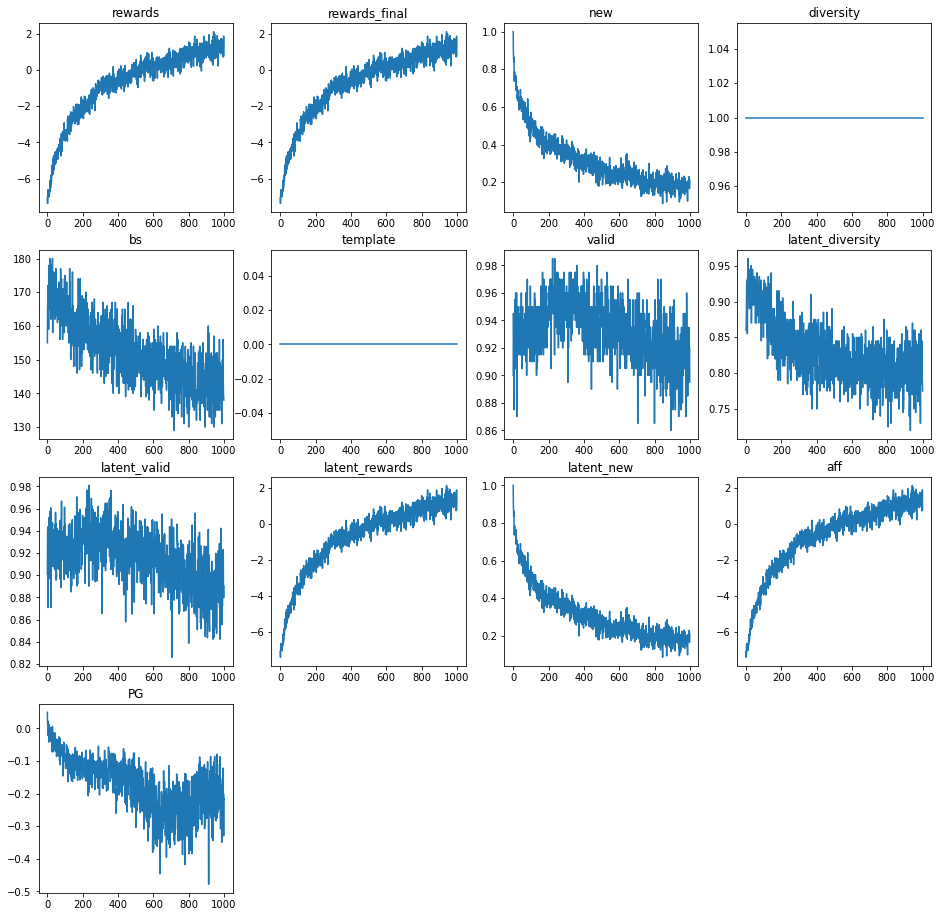

In [ ]:
env.log.plot_metrics()